In [2]:
import pandas as pd
import os
from rxnmapper import RXNMapper
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem

In [3]:
path = '/home/ruard/Documents/datasets/AC_reaxys_export/'
dfs = []
for name in ['amide_coupling_DCM_1.tsv', 'amide_coupling_DCM_2.tsv', 'amide_coupling_DCM_3.tsv', 'amide_coupling_DCM_4.tsv', 'amide_coupling_DCM_5.tsv', 'amide_coupling_DCM_6.tsv']:
    dfs.append(pd.read_csv(os.path.join(path, name), sep='\t'))
    
df = pd.concat(dfs)
print(len(df))

df.columns

35991


Index(['Reaction ID', 'Reaction: Links to Reaxys', 'Data Count',
       'Number of Reaction Details', 'Reaction Rank', 'Record Type',
       'Reactant', 'Product', 'Bin', 'Reaction',
       'Reaction Details: Reaction Classification', 'Example label',
       'Example title', 'Fulltext of reaction', 'Number of Reaction Steps',
       'Multi-step Scheme', 'Multi-step Details', 'Number of Stages',
       'Solid Phase', 'Time (Reaction Details) [h]',
       'Temperature (Reaction Details) [C]',
       'Pressure (Reaction Details) [Torr]', 'pH-Value (Reaction Details)',
       'Other Conditions', 'Reaction Type', 'Subject Studied',
       'Prototype Reaction', 'Named Reaction',
       'Type of reaction description (Reaction Details)', 'Location',
       'Comment (Reaction Details)', 'Product.1', 'Yield', 'Yield (numerical)',
       'Yield (optical)', 'Stage Reactant', 'Reagent', 'Catalyst',
       'Solvent (Reaction Details)', 'References', 'Links to Reaxys',
       'Unnamed: 41'],
      dt

In [4]:
# no NaN reactions 
df = df[~df['Reaction'].isna()]
print(len(df))

# no duplicate reaction smiles
df = df.drop_duplicates(subset=['Reaction'])
print(len(df))

35890
28218


In [5]:
nitrogen_smarts_pattern = Chem.MolFromSmarts('[NH,NH2]')
carboxyl_smarts_pattern = Chem.MolFromSmarts('[#6:1](=[O:2])[OH:3]')

# only do bimolecular reactions for now - with either multiple COOH's or N's
filtered_reaction_ids = []
for reaction, reaction_id in zip(df['Reaction'].values, df['Reaction ID'].values):
    reactants, products = reaction.split('>>')
    if len(reactants.split('.')) == 2: 
        reactant1, reactant2 = reactants.split('.')
        reactant1 = Chem.MolFromSmiles(reactant1)
        reactant2 = Chem.MolFromSmiles(reactant2)
        
        if reactant1 is not None and reactant2 is not None:
            n_matches_1 = reactant1.GetSubstructMatches(nitrogen_smarts_pattern)
            acid_matches_1 = reactant1.GetSubstructMatches(carboxyl_smarts_pattern)
            n_matches_2 = reactant2.GetSubstructMatches(nitrogen_smarts_pattern)
            acid_matches_2 = reactant2.GetSubstructMatches(carboxyl_smarts_pattern)
            
            if (len(n_matches_1) >=2 and len(acid_matches_2) >= 1) or \
               (len(n_matches_1) >=1 and len(acid_matches_2) >= 2) or \
               (len(acid_matches_1) >=2 and len(n_matches_2) >= 1) or \
               (len(acid_matches_1) >=1 and len(n_matches_2) >= 2):
                    filtered_reaction_ids.append(reaction_id)

df = df[df['Reaction ID'].isin(filtered_reaction_ids)]
print(len(df))

1664


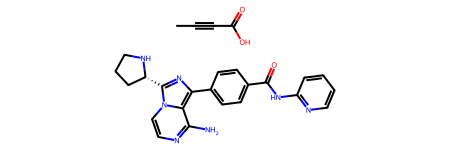

In [6]:
Chem.MolFromSmiles(df['Reaction'].values[6].split('>>')[0])

In [7]:
# filter out reactions with same reactants but different outcomes
df['reactants'] = [r.split('>>')[0] for r in df['Reaction']]

filter_out_reaction_ids = []

for val in df['reactants'].unique():
    if len(df[df['reactants'] == val]) > 2:
        for idx in df[df['reactants'] == val]['Reaction ID'].values:
            filter_out_reaction_ids.append(idx)
        
df = df[~df['Reaction ID'].isin(filter_out_reaction_ids)]
print(len(df))

1650


In [8]:
# see if there could be a regioselective thing
reaction_smarts = AllChem.ReactionFromSmarts(
    "[N,n:1].[*:2][#6:3](=[O:4])[OH:5]>>[N,n:1][#6:3](=[O:4])-[*:2]"
)

def simulate_reaction(substrates):
    products = []
    products += reaction_smarts.RunReactants(substrates)
    substrates = [substrates[1], substrates[0]]
    products += reaction_smarts.RunReactants(substrates)
    
    products = [Chem.MolToSmiles(product[0]) for product in products]
    products = list(set(products))
    products = [Chem.MolFromSmiles(product) for product in products]
    return list(filter(lambda x: x is not None, products))

filtered_reaction_ids = []
idx = 0
for reactants, reaction_id in zip(df['reactants'].values, df['Reaction ID'].values):
    out = simulate_reaction([Chem.MolFromSmiles(smi) for smi in reactants.split('.')])
    if len(out) >= 2:
        filtered_reaction_ids.append(reaction_id)
        
df = df[df['Reaction ID'].isin(filtered_reaction_ids)]
print(len(df))

1609


In [9]:
# now make DataFrame with all reactions

def normalize_mol(mol):
    return Chem.MolFromSmiles(Chem.MolToSmiles(mol, isomericSmiles=False))

reaction_idx = []
substrates = []
products = []
solvents = []
reaction_smiles_list = []
labels = []

for idx, reaction_smiles in enumerate(df['Reaction'].values):
    reactants, product = reaction_smiles.split('>>')
    reactant1_smiles, reactant2_smiles = reactants.split('.')
    
    reactant1 = Chem.MolFromSmiles(reactant1_smiles)
    reactant2 = Chem.MolFromSmiles(reactant2_smiles)
    product = Chem.MolFromSmiles(product)
    reactants = [reactant1, reactant2]
    output = simulate_reaction(reactants)
    
    product_smiles = Chem.MolToSmiles(normalize_mol(product), isomericSmiles=False)
    output = [Chem.MolToSmiles(normalize_mol(mol), isomericSmiles=False) for mol in output]
    output = list(set(output))
    
    if len(output) >= 2 and (product_smiles in output):
        for mol in output:
            reaction_smiles = f"{reactant1_smiles}.{reactant2_smiles}>>{mol}"
            substrates.append(f"{reactant1_smiles}.{reactant2_smiles}")
            products.append(mol)
            solvents.append("CH2Cl2")
            reaction_smiles_list.append(reaction_smiles)
            reaction_idx.append(idx)
            if mol == product_smiles:
                labels.append(1)
            else:
                labels.append(0)   
    
print(len(reaction_idx), len(set(reaction_idx)))    
    
df = pd.DataFrame({
    'reaction_idx': reaction_idx,
    'uid': np.arange(len(reaction_idx)),
    'substrates': substrates,
    'products': products,
    'solvent': solvents,
    'reaction_smiles': reaction_smiles_list,
    'label': labels,
    'simulation_idx': np.zeros(len(reaction_idx))
})    
    
df.to_csv('/home/ruard/code/virtual_reactions/data/datasets/ac/ac_dataset_dcm.csv')

3648 1511
